In [ ]:
!pip install mxnet

In [ ]:
%pylab inline
import mxnet as mx
import pandas as pd
import sys
import seaborn; seaborn.set_style('whitegrid')
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
data_path = '/content/gdrive/My Drive/transaction_all2_with_merch.csv'

In [ ]:
data = pd.read_csv(data_path, sep=',')
data.head()

,customer_id,merchant_id,rating,timestamp,merchant_name_new,behav_category,customer_id_map,mechant_id_map
0,1000000,1000004,1.0,1559779200,13thcuptealounge,dining,1,1
1,1000010,1000004,1.0,1565395200,13thcuptealounge,dining,1,2
2,1000041,1000004,1.0,1577059200,13thcuptealounge,dining,1,3
3,1000111,1000004,1.0,1550016000,13thcuptealounge,dining,1,4
4,1000135,1000004,1.0,1559520000,13thcuptealounge,dining,1,5


In [ ]:
data['rating'].unique()

array([1.        , 1.12195122, 1.36585366, 1.24390244, 1.48780488,
       1.6097561 , 1.73170732, 1.85365854, 1.97560976, 2.09756098,
       2.2195122 , 2.34146342, 2.46341463, 2.95121951, 2.58536585,
       2.70731707, 3.07317073, 3.31707317, 3.56097561, 2.82926829,
       3.43902439, 4.04878049, 3.80487805, 3.19512195, 3.92682927,
       4.41463415, 4.53658537, 5.        , 4.7804878 , 4.17073171,
       3.68292683, 4.29268293, 4.90243902])

In [ ]:
#data = pd.read_csv('transaction_all2_2.csv', sep=',', usecols=(2, 4, 5))

#data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/DeepFM/transaction_all2_with_merch.csv', sep=',')
#data.head()

In [ ]:
#data.rename(columns={"customer_id_map": "userId", "mechant_id_map": "merchantId", "merchant_name_new": "merchantname","behav_category": "category"})

In [ ]:
data = data.rename(columns={"customer_id_map": "userId", "mechant_id_map": "merchantId", "merchant_name_new": "merchantname","behav_category": "category"})
data.head()

,customer_id,merchant_id,rating,timestamp,merchantname,category,userId,merchantId
0,1000000,1000004,1.0,1559779200,13thcuptealounge,dining,1,1
1,1000010,1000004,1.0,1565395200,13thcuptealounge,dining,1,2
2,1000041,1000004,1.0,1577059200,13thcuptealounge,dining,1,3
3,1000111,1000004,1.0,1550016000,13thcuptealounge,dining,1,4
4,1000135,1000004,1.0,1559520000,13thcuptealounge,dining,1,5


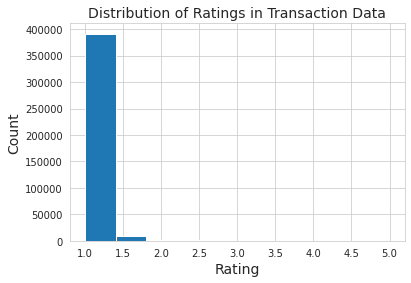

In [ ]:
plt.hist(data['rating'])
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of Ratings in Transaction Data", fontsize=14)
plt.show()

### Looks Ratings 
- Ratings has only 2 value s- 1.0 and 1.5

In [ ]:
n_users, n_merchants = 8699, 8540
batch_size = 2500

In [ ]:
data.shape

(403046, 8)

In [ ]:
n = 303046

data = data.sample(frac=1).reset_index(drop=True) # Shuffle the data in place row-wise

# Use the first 19M samples to train the model
train_users = data['userId'].values[:n] - 1 # Offset by 1 so that the IDs start at 0
train_merchants = data['merchantId'].values[:n] - 1 # Offset by 1 so that the IDs start at 0
train_ratings = data['rating'].values[:n]

# Use the remaining ~1M samples for validation of the model
valid_users = data['userId'].values[n:] - 1 # Offset by 1 so that the IDs start at 0
valid_merchants = data['merchantId'].values[n:] - 1 # Offset by 1 so that the IDs start at 0
valid_ratings = data['rating'].values[n:]

In [ ]:
valid_ratings

array([1.12195122, 1.        , 1.        , ..., 1.24390244, 1.        ,
       1.12195122])

In [ ]:
valid_merchants,valid_ratings,valid_users

(array([2480,  148, 1823, ..., 7203,  526, 2511]),
 array([1.12195122, 1.        , 1.        , ..., 1.24390244, 1.        ,
        1.12195122]),
 array([ 304, 7511,  535, ..., 1688, 2815, 1821]))

In [ ]:
valid_users

array([ 304, 7511,  535, ..., 1688, 2815, 1821])

In [ ]:
train_users

array([ 767, 2876,  318, ..., 7982, 3231, 1284])

In [ ]:
train_merchants

array([ 448,  276, 4616, ...,  705, 3469, 2366])

In [ ]:
train_ratings

array([1.12195122, 1.        , 1.12195122, ..., 1.        , 1.36585366,
       1.        ])

In [ ]:
#Deep matrix factorization
X_train = mx.io.NDArrayIter({'user': train_users, 'merchant': train_merchants}, 
                            label=train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 'merchant': valid_merchants}, 
                           label=valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25)

merchant = mx.symbol.Variable("merchant")
merchant = mx.symbol.Embedding(data=merchant, input_dim=n_merchants, output_dim=25)

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, merchant)
nn = mx.symbol.flatten(nn)

# Since we are using a two layer neural network here, we will create two FullyConnected layers
# with activation functions before the output layer
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'merchant'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Train-rmse=0.485840
INFO:root:Epoch[0] Time cost=2.031
INFO:root:Epoch[0] Validation-rmse=0.138382
INFO:root:Epoch[1] Train-rmse=0.128530
INFO:root:Epoch[1] Time cost=2.020
INFO:root:Epoch[1] Validation-rmse=0.127894
INFO:root:Epoch[2] Train-rmse=0.124793
INFO:root:Epoch[2] Time cost=2.026
INFO:root:Epoch[2] Validation-rmse=0.127387
INFO:root:Epoch[3] Train-rmse=0.124401
INFO:root:Epoch[3] Time cost=2.016
INFO:root:Epoch[3] Validation-rmse=0.127418
INFO:root:Epoch[4] Train-rmse=0.124211
INFO:root:Epoch[4] Time cost=2.051
INFO:root:Epoch[4] Validation-rmse=0.127396


In [ ]:
category = data
category.head()

,customer_id,merchant_id,rating,timestamp,merchantname,category,userId,merchantId
0,1004586,1002565,1.121951,1553644800,frankautocarspacentre,miscellaneous stores,768,449
1,1004486,1005088,1.000000,1553385600,orraspa,apparel and accessories,2877,277
2,1003016,1008199,1.121951,1555545600,vishnuclothstore,apparel and accessories,319,4617
3,1000093,1002127,1.000000,1547942400,eatindiacompany,dining,3353,387
4,1007841,1003733,1.000000,1547942400,kholanis,dining,5109,479


In [ ]:
labels_str = [label for label in category['category']]
label_set = numpy.unique(labels_str)
label_idxs = {l: i for i, l in enumerate(label_set)}
label_idxs

{'apparel and accessories': 0,
 'dining': 1,
 'entertainment': 2,
 'miscellaneous stores': 3,
 'personal service providers': 4,
 'retail stores': 5,
 'travel': 6}

In [ ]:
labels = np.empty(n_merchants)
for merchantId, label in zip(category['merchantId'], labels_str):
    labels[merchantId-1] = label_idxs[label]

train_category = np.array([labels[int(j)] for j in train_merchants])
valid_category = np.array([labels[int(j)] for j in valid_merchants])
train_category[:10]

array([2., 5., 1., 1., 1., 1., 2., 1., 6., 3.])

In [ ]:
X_train = mx.io.NDArrayIter({'user': train_users, 'merchant': train_merchants, 'merchant_category': train_category}, 
                            label=train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 'merchant': valid_merchants, 'merchant_category': valid_category}, 
                           label=valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=15)

merchant = mx.symbol.Variable("merchant")
merchant = mx.symbol.Embedding(data=merchant, input_dim=n_merchants, output_dim=20) # Reduce from 25 to 20

# We need to add in a third embedding layer for genre
merchant_category = mx.symbol.Variable("merchant_category")
merchant_category = mx.symbol.Embedding(data=merchant_category, input_dim=20, output_dim=5) # Set to 5

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, merchant, merchant_category)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'merchant', 'merchant_category'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Train-rmse=0.466198
INFO:root:Epoch[0] Time cost=2.079
INFO:root:Epoch[0] Validation-rmse=0.138440
INFO:root:Epoch[1] Train-rmse=0.128558
INFO:root:Epoch[1] Time cost=2.077
INFO:root:Epoch[1] Validation-rmse=0.127987
INFO:root:Epoch[2] Train-rmse=0.124106
INFO:root:Epoch[2] Time cost=2.109
INFO:root:Epoch[2] Validation-rmse=0.126899
INFO:root:Epoch[3] Train-rmse=0.123410
INFO:root:Epoch[3] Time cost=2.113
INFO:root:Epoch[3] Validation-rmse=0.126790
INFO:root:Epoch[4] Train-rmse=0.123104
INFO:root:Epoch[4] Time cost=2.112
INFO:root:Epoch[4] Validation-rmse=0.126736


### Inferenec Experiment

In [ ]:
all_category = np.array([labels[int(j)] for j in train_merchants] + [labels[int(j)] for j in valid_merchants])


In [ ]:
all_category.shape

(403046,)

In [ ]:
all_users = data['userId'].values[:] - 1 # Offset by 1 so that the IDs start at 0
all_merchants = data['merchantId'].values[:] - 1 # Offset by 1 so that the IDs start at 0
all_ratings = data['rating'].values[:]


In [ ]:
all_user_merchants_pred_iter = mx.io.NDArrayIter({'user': all_users, 'merchant': all_merchants, 'merchant_category': all_category}, 
                           label=all_ratings, batch_size=batch_size)


In [ ]:
all_user_merchants_pred_rating = model.predict(all_user_merchants_pred_iter)

In [ ]:
list_of_pred_ratings = all_user_merchants_pred_rating.squeeze()

In [ ]:
type(list_of_pred_ratings)

mxnet.ndarray.ndarray.NDArray

In [ ]:
list_of_pred_ratings = list_of_pred_ratings.asnumpy()

In [ ]:
type(list_of_pred_ratings)

numpy.ndarray

In [ ]:
list_of_pred_ratings.shape

(403046,)

In [ ]:
data.shape

(403046, 8)

In [ ]:
data['currrent_prediction'] = list_of_pred_ratings

In [ ]:
data.head()

,customer_id,merchant_id,rating,timestamp,merchantname,category,userId,merchantId,currrent_prediction
0,1004586,1002565,1.121951,1553644800,frankautocarspacentre,miscellaneous stores,768,449,1.128705
1,1004486,1005088,1.000000,1553385600,orraspa,apparel and accessories,2877,277,1.019512
2,1003016,1008199,1.121951,1555545600,vishnuclothstore,apparel and accessories,319,4617,1.002205
3,1000093,1002127,1.000000,1547942400,eatindiacompany,dining,3353,387,0.989308
4,1007841,1003733,1.000000,1547942400,kholanis,dining,5109,479,1.004806


### Framing Meta info for User, merchant-category

In [ ]:
all_users[0:3]

array([ 767, 2876,  318])

In [ ]:
## Needed
all_unique_users = np.unique(all_users)

In [ ]:
all_unique_users.shape

(8699,)

In [ ]:
all_category.shape

(403046,)

In [ ]:
all_merchants.shape

(403046,)

In [ ]:
all_merchant_category = np.zeros(shape=(all_merchants.shape[0], 2))

In [ ]:
all_merchant_category[:,0] = all_merchants
all_merchant_category[:,1] = all_category

In [ ]:
all_merchant_category_df = pd.DataFrame(all_merchant_category)

In [ ]:
all_merchant_category_uniq = all_merchant_category_df.drop_duplicates()

In [ ]:
## 
all_merchant_category_uniq = all_merchant_category_uniq.to_numpy()

In [ ]:
all_merchant_category_uniq.shape

(8540, 2)

In [ ]:
all_merchant_category_uniq[:3]

array([[4.480e+02, 2.000e+00],
       [2.760e+02, 5.000e+00],
       [4.616e+03, 1.000e+00]])

### Infernce for particular user

In [ ]:
userId = 438
user_feature_over_all_merchants = np.repeat(userId, all_merchant_category_uniq.shape[0])
# user_feature_over_all_merchants.shape
print(train_merchants.shape)
print(all_merchant_category_uniq[:,0].shape)

(303046,)
(8540,)


In [ ]:
user_feature_over_all_merchants = np.repeat(userId, all_merchant_category_uniq.shape[0])
custom_inputs = mx.io.NDArrayIter({'user': user_feature_over_all_merchants, 
                                   'merchant': all_merchant_category_uniq[:,0], 
                                   'merchant_category': all_merchant_category_uniq[:,1]},
                                  batch_size=batch_size)
pred_ratings = model.predict(custom_inputs)

In [ ]:
pred_ratings.shape

(8540, 1)

In [ ]:
pred_ratings[:3]


[[0.9967408 ]
 [1.0020721 ]
 [0.97544664]]
<NDArray 3x1 @cpu(0)>

In [ ]:
pred_ratings.squeeze().sort()


[0.73886275 0.7693501  0.8419582  ... 1.128924   1.15651    1.1663806 ]
<NDArray 8540 @cpu(0)>

In [ ]:
pred_ratings.squeeze().argsort()


[8297. 5494. 8535. ... 7534. 4254. 6487.]
<NDArray 8540 @cpu(0)>

In [ ]:
# https://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order

In [ ]:
topk = pred_ratings.squeeze().argsort()[::-1][:20]

In [ ]:
topk = topk.asnumpy()

In [ ]:
topk

array([6487., 4254., 7534., 6661., 5440., 5454., 6563., 6787., 2723.,
        496., 4924., 8327., 7335., 1229., 6445., 8281.,  611., 3516.,
       2724., 1962.], dtype=float32)

In [ ]:
type(all_merchant_category_uniq)

numpy.ndarray

In [ ]:
topk = [int(k) for k in topk]

In [ ]:
for k in topk:
  print(tuple(all_merchant_category_uniq[k, :]))

(5254.0, 4.0)
(1343.0, 0.0)
(7561.0, 0.0)
(7184.0, 5.0)
(2805.0, 5.0)
(2092.0, 6.0)
(2663.0, 5.0)
(7119.0, 5.0)
(4881.0, 5.0)
(5872.0, 6.0)
(6642.0, 1.0)
(7222.0, 3.0)
(7018.0, 1.0)
(7731.0, 6.0)
(3561.0, 5.0)
(5542.0, 1.0)
(6881.0, 2.0)
(4377.0, 6.0)
(4018.0, 6.0)
(1385.0, 3.0)


In [ ]:
def find_rating_for_user(userId):

  merchants = list() 

  if userId in all_unique_users:
    # valid user
    user_feature_over_all_merchants = np.repeat(userId, all_merchant_category_uniq.shape[0])
    custom_inputs = mx.io.NDArrayIter({'user': user_feature_over_all_merchants, 
                                       'merchant': all_merchant_category_uniq[:,0], 
                                       'merchant_category': all_merchant_category_uniq[:,1]},
                                      batch_size=batch_size)
    pred_ratings = model.predict(custom_inputs)
    topk = pred_ratings.squeeze().argsort()[::-1][:20]
    topk = topk.asnumpy()
    topk = [int(k) for k in topk]
    for k in topk:
      # print(tuple(all_merchant_category_uniq[k, :]))
      merchants.append(tuple(all_merchant_category_uniq[k, :]))




  else:
    # Invalid user
    print('Invalid User')
    pass
  return merchants


In [ ]:
find_rating_for_user(438)

[(5254.0, 4.0),
 (1343.0, 0.0),
 (7561.0, 0.0),
 (7184.0, 5.0),
 (2805.0, 5.0),
 (2092.0, 6.0),
 (2663.0, 5.0),
 (7119.0, 5.0),
 (4881.0, 5.0),
 (5872.0, 6.0),
 (6642.0, 1.0),
 (7222.0, 3.0),
 (7018.0, 1.0),
 (7731.0, 6.0),
 (3561.0, 5.0),
 (5542.0, 1.0),
 (6881.0, 2.0),
 (4377.0, 6.0),
 (4018.0, 6.0),
 (1385.0, 3.0)]

### Inference for particular Merchant

In [ ]:
def find_rating_for_a_merchant(merchantId):
  if merchantId in all_merchant_category_uniq[:,0]:

    current_merchant_index = np.where(all_merchant_category_uniq[:,0], merchantId)

    custom_inputs = mx.io.NDArrayIter({'user': all_unique_users, 
                                       'merchant': all_merchant_category_uniq[current_merchant_index,0], 
                                       'merchant_category': all_merchant_category_uniq[current_merchant_index,1]},
                                      batch_size=batch_size)
    pred_ratings = model.predict(custom_inputs)
    pred_ratings = pred_ratings.squeeze()

    topk = [int(k) for k in topk]
    



In [ ]:
## Particular User id 438

In [ ]:
user_438 = np.where(all_users == 438)

In [ ]:
user_438[:]

(array([54793, 54794, 54795, 54796, 54797, 54798, 54799, 54800, 54801,
        54802, 54803, 54804, 54805, 54806, 54807, 54808, 54809, 54810,
        54811, 54812, 54813, 54814, 54815, 54816, 54817, 54818, 54819,
        54820, 54821, 54822, 54823, 54824, 54825, 54826, 54827, 54828,
        54829, 54830, 54831, 54832, 54833, 54834, 54835, 54836, 54837,
        54838, 54839, 54840, 54841, 54842, 54843, 54844, 54845, 54846,
        54847, 54848, 54849, 54850, 54851, 54852, 54853, 54854, 54855,
        54856, 54857, 54858, 54859, 54860, 54861, 54862, 54863, 54864,
        54865, 54866, 54867, 54868, 54869, 54870, 54871, 54872, 54873,
        54874, 54875, 54876, 54877, 54878, 54879, 54880, 54881, 54882,
        54883, 54884, 54885, 54886, 54887, 54888, 54889, 54890, 54891,
        54892, 54893, 54894, 54895, 54896, 54897, 54898, 54899, 54900,
        54901, 54902, 54903, 54904, 54905, 54906, 54907, 54908, 54909,
        54910, 54911, 54912, 54913, 54914, 54915, 54916, 54917, 54918]),)

In [ ]:
all_merchants[user_438]

array([   2, 3716, 2403,   10,  205,  385,  386, 3844, 1229,  838, 6307,
       4359, 1504,  390,  625, 6925,  847, 6243, 1039, 2088, 5478, 1740,
        853, 6524, 3660, 3351, 1659,  638,   38, 1745, 5346, 4422, 1853,
         42, 6926,  863, 6436,  511, 4194, 6927, 6928, 6929, 2782, 3203,
        410,  412, 6482, 3205,   59,  659,  255, 6409,   64,  665, 4532,
       1864, 4822,   73,  423,  669, 5350,  876,  425,  780, 1548, 4263,
       5788, 1071, 6129,  675,   84,   90, 3911,  789,  100, 6930,  437,
       2666, 5353, 6132, 4049, 1791, 6871,  690, 6899, 2672,  139,  448,
        316,  450, 5860,  146, 3058, 1460,  151,  910, 5359,  452, 4547,
        454, 5626,  456,  811, 1359, 2917, 6931,  918, 2305,  159, 6775,
       2466, 1824, 2068,  175, 3246, 5147, 3338,  740, 3247, 2072,  183,
       3304, 4553,  478, 1914, 1143])

In [ ]:
all_category[user_438]

array([1., 4., 4., 4., 1., 4., 4., 4., 4., 4., 0., 4., 4., 4., 4., 4., 1.,
       4., 1., 1., 1., 4., 0., 4., 4., 4., 4., 4., 1., 4., 1., 0., 4., 5.,
       4., 4., 4., 4., 1., 4., 4., 4., 1., 0., 4., 4., 1., 4., 2., 1., 1.,
       4., 4., 1., 4., 1., 4., 4., 4., 0., 4., 1., 0., 2., 4., 4., 4., 4.,
       4., 4., 4., 4., 1., 4., 4., 1., 4., 4., 4., 4., 4., 4., 4., 4., 1.,
       4., 4., 1., 4., 4., 2., 4., 4., 4., 4., 1., 4., 4., 4., 1., 0., 4.,
       4., 4., 4., 4., 1., 1., 4., 4., 4., 4., 4., 1., 4., 4., 0., 4., 4.,
       4., 4., 1., 4., 4., 4., 4.])

In [ ]:
# user  in all_users 
# merchants in all_merchants

In [ ]:
np.unique(all_merchants).shape 

(8540,)

In [ ]:
all_merchants.shape

(403046,)